---
file: temp_demos/end_to_end_training_pipeline_in_ivy.ipynb
---

# End-to-End Training Pipeline in Ivy

ToDo: description

::::: {#colab-button}
[![Open in Colab]({{< var remote_badge.colab >}})](https://colab.research.google.com/github/unifyai/demos/blob/main/{{< meta file >}})
[![GitHub]({{< var remote_badge.github >}})](https://github.com/unifyai/demos/blob/main/{{< meta file >}})
:::::

In [1]:
# install the latest Ivy version for this purpose
!pip install git+https://github.com/unifyai/ivy.git@master

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/unifyai/ivy.git (to revision master) to /tmp/pip-req-build-_3r2_73j
  Running command git clone --filter=blob:none --quiet https://github.com/unifyai/ivy.git /tmp/pip-req-build-_3r2_73j
  Resolved https://github.com/unifyai/ivy.git to commit 0edf8c1e8ea835f4c456bdf89737d89032f50b5a
  Running command git submodule update --init --recursive -q
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.1/281.1 KB 10.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 KB 4.7 MB/s eta 0:00:00
  Created wheel for ivy-core: filename=ivy_core-1.1.9-py3-none-any.whl size=1297564 sha256=05fcafac1e19fec835a9ac61270b3ac6039a5095f6b0f9fde20bacc2a5abba45
  Stored in directory: /tmp/pip-ephem-wheel-cache-le3bu3_v/wheels/07/46/2e/ae2d7c5ce8708e605368a33e08d57d1de8e107e3db157c3063
  C

# Importing libraries


In [1]:
# third party libraries
import ivy

# built-in libraries
import os
import random
import csv
from tqdm import tqdm
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import numpy as np
import pandas as pd

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!mkdir /content/drive/MyDrive/Ivy/
os.chdir('/content/drive/MyDrive/Ivy')

# Let's build the pipeline with a Tensorflow backend

One can experiment with any other backend as well. Just add the following line at the start with the string name to be the framework you want. 


In [12]:
ivy.set_backend("tensorflow")

# We are using MNIST dataset for this Tutorial

Now we will download the MNIST dataset from Kaggle using its API. More details in this [medium](https://medium.com/swlh/image-classifcation-with-google-colab-183e95bfc439#:~:text=Download%20datasets%20directly%20to%20colab%20using%20kaggle%20API.&text=After%20uploading%20the%20JSON%20file,store%20it%20into%20data%20frames.&text=After%20this%2C%20additional%20data%20frames,images%20to%20train%20the%20model) article.

In [15]:
!mkdir /root/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


Insert the `kaggle.json` file in the `/root/.kaggle` folder. You can download the file here `https://www.kaggle.com/{your_kaggle_username}/account` by clicking on `Create New API Token`

In [18]:
!kaggle competitions download -c digit-recognizer 
!unzip digit-recognizer.zip

digit-recognizer.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  digit-recognizer.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [19]:
#Import pandas and read training and testing data in data frames
import pandas as pd 
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [ ]:
# Set the PATH string that will be used to save the dataset in your Google Drive folder, it will be used later to load the dataset
PATH = '/content/drive/My Drive/mnist'

In [43]:
#Create a data frame to store labels, another without labels, df with values only, test value df and a path variable to set location of where to store images
label_df = train['label']
mod_train = train.drop(columns= 'label')
data_values = mod_train.values
test_data_values = test.values

In [44]:
for i in range(0, len(data_values)):
    #read the correct label
    correct_label = label_df[i]

    #split the data into training and validation sets
    if np.random.rand() < 0.8:
        folder = '/train/'
        train_path = f'{PATH}' + '/train/' + str(correct_label)
        if not os.path.exists(train_path):
          os.makedirs(train_path)
    else:
        folder = '/valid/'
        valid_path = f'{PATH}' + '/valid/' + str(correct_label)
        if not os.path.exists(valid_path):
          os.makedirs(valid_path)
    img = data_values[i][:]
    #reshape into 28x28 pic
    img = img.reshape(28,28)
    #we need three channels into the picture
    img = np.stack((img,)*3,axis = -1)
    #change the data type to int8
    img = np.uint8(img)
    #create PIL Image
    new_img = Image.fromarray(img)
    #save the .jpg into correct folder
    new_img.save(f'{PATH}' + folder + str(correct_label) + '/' + str(i) + '.jpg', 'JPEG')

# Temporary Dataset and Dynamic loader

Since we don't have the builder ready just yet, we will create three functions which help in generating the dataset, randomizing, and batchwise loading at training time. 

**Note** -  We're only using a small subset of the entire dataset for the purpose of this demo. Same goes for the number of `epochs` we train the model for.

Let's set a global seed for randomized operations

In [20]:
ivy.seed(seed_value = 0)

In [65]:
def randomize_dataset(images, classes):
    data = list(zip(images, classes))
    random.shuffle(data)
    images, classes = zip(*data)
    return list(images), list(classes)

 
def create_dataset(folder, num_examples_per_class = 100):
    img_array = []
    class_name = []
    for dir in os.listdir(folder):
        for i, file in enumerate(os.listdir(os.path.join(folder, dir))):
            if i >= num_examples_per_class:
                continue
            img_path = os.path.join(folder, dir, file)
            image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            image = ivy.array(image).astype('float32').expand_dims()
            image /= 255
            img_array.append(image) 
            class_name.append(dir)
    
    return randomize_dataset(img_array, class_name)


def generate_batches(images, classes, dataset_size, batch_size = 32):
    targets={k: v for v, k in enumerate(np.unique(classes))}
    y_train= [targets[classes[i]] for i in range(len(classes))]
    if batch_size > dataset_size:
        raise ivy.utils.exceptions.IvyError('Use a smaller batch size')
    for idx in range(0, dataset_size, batch_size):
        yield ivy.stack(images[idx:min(idx+batch_size, dataset_size)]), ivy.array(y_train[idx:min(idx+batch_size, dataset_size)])


#choosing 1000 examples per class for this demo
images, classes = create_dataset(PATH + '/train',num_examples_per_class = 1000)

In [66]:
print(f'Number of Training Examples is -: {len(images)}')

Number of Training Examples is -: 10000


In [47]:
targets = {k: v for v, k in enumerate(np.unique(classes))}
print(f"Class labels -: {targets}")

Class labels -: {'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9}


In [48]:
x_batch_instance, y = next(iter(generate_batches(images, classes, len(images))))
print(f"Data is of the form -: {x_batch_instance.shape} (NCHW)\n")
print(y.shape[0], y)

Data is of the form -: (32, 1, 28, 28) (NCHW)

32 ivy.array([2, 6, 8, 8, 3, 6, 0, 3, 6, 4, 1, 5, 8, 3, 8, 7, 4, 7, 1, 0, 0, 7,
       9, 8, 2, 0, 2, 8, 8, 9, 1, 2], dev=gpu:0)


Intialising some training parameters

In [49]:
optimizer= ivy.Adam(1e-4)
batch_size = 64 
num_epochs = 20
num_classes = 10

# Defining the Ivy Network

We inherit from the `ivy.Module` class for creation of networks. This helps us with the forward pass and computation of the gradients. Note that some keyword arguments below are user-defined, and are purely for the purpose of building this model. You can find more information about the `init` method inside the docs.

In [50]:
class IvyNet(ivy.Module):
    def __init__(self, h_w = (32, 32), input_channels = 3,  output_channels = 512, kernel_size = [3, 3], num_classes = 2, data_format = "NCHW", device = "cpu"):
        self.extractor = ivy.Sequential(
            ivy.Conv2D(input_channels, 6, [5, 5], 1,  "SAME", data_format = data_format),
            ivy.GELU(),
            ivy.Conv2D(6,  16,  [5, 5], 1,  "SAME", data_format = data_format),
            ivy.GELU(),
            ivy.Conv2D(16, output_channels, [5, 5],  1,  "SAME", data_format = data_format),
            ivy.GELU()
        )
        
        self.classifier = ivy.Sequential(
            ivy.Linear(h_w[0]*h_w[1]*output_channels, 512), #since padding is same, this would be image_height x image_widht x output_channels
            ivy.GELU(),
            ivy.Linear(512, num_classes)
        )
        ivy.Module.__init__(self)

    def _forward(self, x):
        x = self.extractor(x)
        x = ivy.flatten(x, start_dim = 1, end_dim = -1) #flatten all dims except batch dim
        logits = self.classifier(x)
        probs = ivy.softmax(logits)
        return logits, probs

# train the model on gpu if it's available
device = "cuda:0" if ivy.gpu_is_available() else "cpu"

model = IvyNet(h_w = (28, 28), input_channels = 1, output_channels = 120, kernel_size = [5,5], num_classes = num_classes, device = device)
model_name = type(model).__name__.lower()

In [51]:
print(device, model_name)

cuda:0 ivynet


# Training Loop with utility functions

The `train` function is where we do the heavy lifting, and use the `loss_fn` to compute the gradients. `num_correct` is used for returning the correct set of predictions.

In [63]:
def num_correct(preds, labels):
    return (preds.argmax() == labels).sum().to_numpy().item()

def loss_fn(params):
    v, model, x, y = params
    y_pred, probs = model(x)
    return ivy.cross_entropy(y, probs), probs

def train(images, classes, epochs, model, device, num_classes = 10, batch_size = 32):
    # training metrics
    epoch_loss = 0.0
    running_loss = 0.0
    fields = ['epoch', 'epoch_loss', 'training_accuracy']
    metrics = []
    dataset_size = len(images)
    
    for epoch in range(epochs):
        train_loss, train_correct = 0, 0
        train_loop = tqdm(generate_batches(images, classes, len(images), batch_size = batch_size), total = dataset_size//batch_size
        , position = 0, leave = True)
        
        for xbatch, ybatch in train_loop:
            print(xbatch.shape)
            print(ybatch.shape)
            if device != "cpu":
                 xbatch, ybatch = xbatch.to_device("gpu:0"), ybatch.to_device("gpu:0")

            # since the cross entropy function expects the target classes to be in one-hot encoded format
            ybatch_encoded = ivy.one_hot(ybatch, num_classes)
            
            # update model params
            loss_probs, grads = ivy.execute_with_gradients(loss_fn, (model.v, model, xbatch, ybatch_encoded), ret_grad_idxs = [[0]], xs_grad_idxs = [[0]])
            model.v = optimizer.step(model.v, grads['0'])
            
            batch_loss = ivy.to_numpy(loss_probs[0]).mean().item() # batch mean loss
            epoch_loss +=  batch_loss * xbatch.shape[0]
            train_correct += num_correct(loss_probs[1], ybatch)

            train_loop.set_description(f'Epoch [{epoch+1:2d}/{epochs}]')
            train_loop.set_postfix(
                running_loss=batch_loss, accuracy_percentage=(train_correct/dataset_size)*100
            )
        epoch_loss = epoch_loss/dataset_size
        training_accuracy = train_correct/dataset_size

      
        metrics.append([epoch, epoch_loss, training_accuracy])

        train_loop.write(
                f'\nAverage training loss: {epoch_loss:.6f}, Train Correct: {train_correct}', end='\n'
            )

    # write metrics for plotting
    with open(f'/{model_name}_train_summary.csv', 'w') as f:
        f = csv.writer(f)
        f.writerow(fields)
        f.writerows(metrics)

In [ ]:
train(images, classes, num_epochs, model, device, num_classes = num_classes, batch_size = batch_size)

Epoch [ 1/20]: : 157it [01:16,  2.06it/s, accuracy_percentage=0.2, running_loss=0.29]



Average training loss: 0.475401, Train Correct: 20


Epoch [ 2/20]: : 157it [01:14,  2.11it/s, accuracy_percentage=0.14, running_loss=0.12]



Average training loss: 0.081436, Train Correct: 14


Epoch [ 3/20]: : 157it [01:13,  2.13it/s, accuracy_percentage=0.19, running_loss=0.0187]



Average training loss: 0.029279, Train Correct: 19


Epoch [ 4/20]: : 157it [01:14,  2.11it/s, accuracy_percentage=0.36, running_loss=0.0324]



Average training loss: 0.008382, Train Correct: 36


Epoch [ 5/20]: : 157it [01:15,  2.07it/s, accuracy_percentage=0.6, running_loss=0.00456]



Average training loss: 0.003816, Train Correct: 60


Epoch [ 6/20]: : 157it [01:26,  1.82it/s, accuracy_percentage=0.6, running_loss=0.00277]



Average training loss: 0.002179, Train Correct: 60


Epoch [ 7/20]: : 157it [01:16,  2.05it/s, accuracy_percentage=0.81, running_loss=0.00175]



Average training loss: 0.001569, Train Correct: 81


Epoch [ 8/20]: : 157it [01:14,  2.11it/s, accuracy_percentage=0.81, running_loss=0.00147]



Average training loss: 0.001235, Train Correct: 81


Epoch [ 9/20]: : 157it [01:14,  2.09it/s, accuracy_percentage=1.06, running_loss=0.00128]



Average training loss: 0.001005, Train Correct: 106


Epoch [10/20]: : 157it [01:14,  2.10it/s, accuracy_percentage=1.29, running_loss=0.00112]



Average training loss: 0.000837, Train Correct: 129


Epoch [11/20]: : 157it [01:13,  2.12it/s, accuracy_percentage=1.45, running_loss=0.000989]



Average training loss: 0.000709, Train Correct: 145


Epoch [12/20]: : 157it [01:15,  2.07it/s, accuracy_percentage=1.68, running_loss=0.000873]



Average training loss: 0.000606, Train Correct: 168


Epoch [13/20]: : 157it [01:15,  2.08it/s, accuracy_percentage=1.77, running_loss=0.000774]



Average training loss: 0.000524, Train Correct: 177


Epoch [14/20]: : 157it [01:15,  2.09it/s, accuracy_percentage=1.92, running_loss=0.000688]



Average training loss: 0.000455, Train Correct: 192


Epoch [15/20]: : 157it [01:13,  2.13it/s, accuracy_percentage=1.92, running_loss=0.000613]



Average training loss: 0.000398, Train Correct: 192


Epoch [16/20]: : 157it [01:13,  2.12it/s, accuracy_percentage=2.05, running_loss=0.000547]



Average training loss: 0.000350, Train Correct: 205


Epoch [17/20]: : 157it [01:13,  2.13it/s, accuracy_percentage=2.18, running_loss=0.000488]



Average training loss: 0.000308, Train Correct: 218


Epoch [18/20]: : 157it [01:13,  2.13it/s, accuracy_percentage=2.25, running_loss=0.000437]



Average training loss: 0.000273, Train Correct: 225


Epoch [19/20]: : 157it [01:14,  2.10it/s, accuracy_percentage=2.38, running_loss=0.000391]



Average training loss: 0.000243, Train Correct: 238


Epoch [20/20]: : 157it [01:19,  1.98it/s, accuracy_percentage=2.6, running_loss=0.000351]


Average training loss: 0.000216, Train Correct: 260


# Plotting the training metrics
 

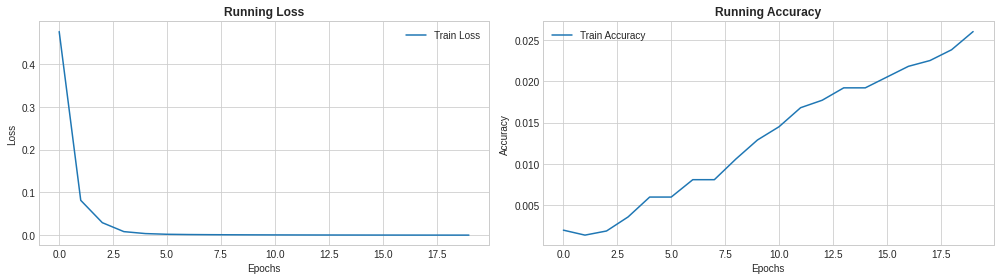

In [ ]:
def plot_summary(path):
    data = pd.read_csv(path)

    plt.style.use('seaborn-whitegrid')
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 4))

    ax1.plot(data['epoch'], data['epoch_loss'], label='Train Loss')
    ax2.plot(data['epoch'], data['training_accuracy'], label='Train Accuracy')

    ax1.legend()
    ax1.set_title('Running Loss', fontweight='bold')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.grid(True)

    ax2.legend()
    ax2.set_title('Running Accuracy', fontweight='bold')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.grid(True)

    plt.tight_layout()
    fig.savefig(f'summary_plots.png')
    plt.show()
    plt.close()


plot_summary(f'/{model_name}_train_summary.csv')

# Save the trained Model

In [ ]:
model.save_weights('model_params/ivynet_weights.hdf5')